In [1]:
import sys
sys.path.append('/home/nick/workspace/zoo-aquifer')

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx
import numpy as np
import pymannkendall as mk
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import statsmodels.formula.api as smf
import statsmodels.api as sm
from utils import viz

### Bring in data

In [2]:
df_raw = pd.read_csv('../data/missoula_valley_monitored_wells.csv', parse_dates=['time'], index_col='time')
df_filled = pd.read_csv('../data/missoula_valley_wells_imputed_wells.csv')
df_static = pd.read_csv('../data/static_variables.csv')
df_dyn = pd.read_csv('../data/dynamic_variables_norm.csv', index_col=0, parse_dates=True)
df_norm = pd.read_csv('../data/dynamic_variables_all_normalized.csv', index_col=0, parse_dates=True)

In [3]:
# Multiply depths by -1
df_raw = -df_raw
depth_cols = [i for i in df_filled.columns if not i in ['time', 'Q', 'pumping_rate']]
for col in depth_cols:
    df_filled[col] *= -1
    df_dyn[col] *= -1    

### Heatmap of all data and gaps

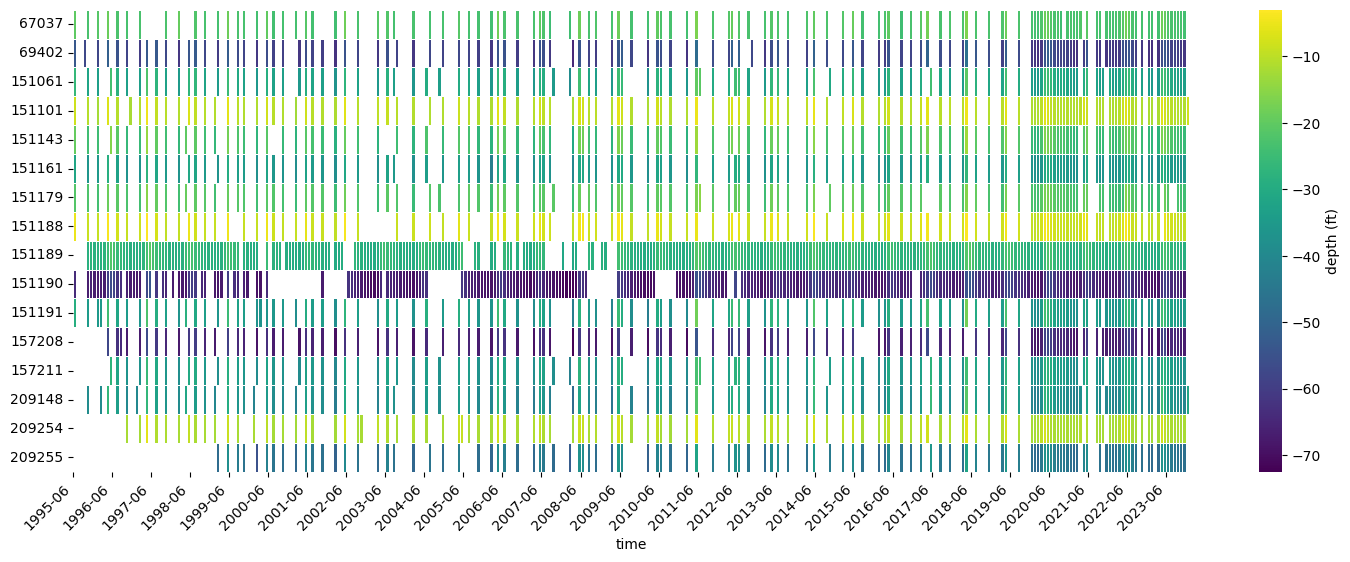

In [4]:
fig, ax = plt.subplots(figsize=(18, 6))
fig = sns.heatmap(df_raw.transpose(), 
                  cmap='viridis', 
                  cbar=True, 
                  linewidth=0.5, 
                  ax=ax, 
                  cbar_kws={'label': 'depth (ft)'})
xdates = df_raw.index.strftime('%Y-%m').sort_values().unique()
step = 12
ax.set_xticks(np.arange(0, len(xdates), step=step))
ax.set_xticklabels(xdates[::step], rotation=45, ha='right')
plt.show()

### Plot timeseries of all wells

In [5]:
# Clip data to full water years for all wells

df_filled = df_filled[(df_filled['time'] >= '1999-10-01') & (df_filled['time'] <= '2023-09-30')]
df_dyn = df_dyn[(df_dyn.index >= '1999-10-01') & (df_dyn.index <= '2023-09-30')]
df_norm = df_norm[(df_norm.index >= '1999-10-01') & (df_norm.index <= '2023-09-30')]
df_melt = df_filled.drop(columns='Q').melt(id_vars='time')
df_melt['time'] = pd.to_datetime(df_melt['time'])

In [6]:
# Calculate trends and p-values and add to the DataFrame
df_trend = df_melt.copy()
df_trend['timestamp'] = df_trend['time'].apply(lambda x: x.timestamp() if pd.notnull(x) else x)

# Group the data by the 'variable' column and apply the 'get_trend' function
trends = df_trend.groupby('variable').apply(viz.get_mk_trend)

# Join the 'trends' DataFrame with the 'df_trend' DataFrame
df_trend = df_trend.join(trends, on='variable')

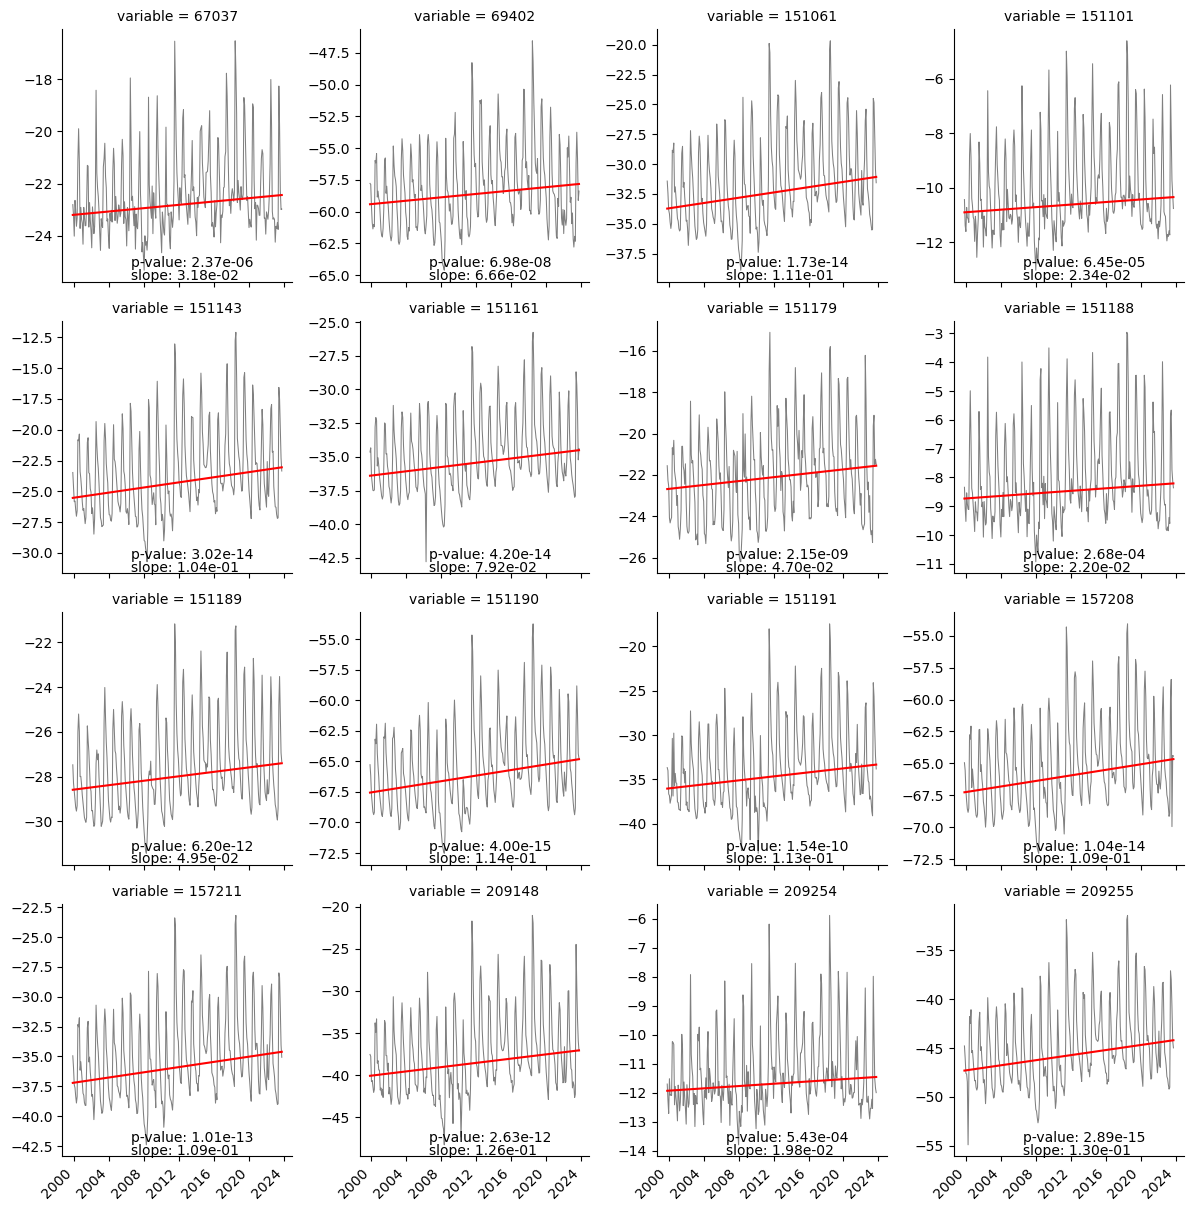

In [7]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_trendline, mann_kendall=True)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

In [17]:
len(df_norm)/12

24.0

In [20]:
trends['slope'].mean()

0.0784134948448244

In [22]:
trends['slope'].mean()*(len(df_norm)/12)

1.8819238762757857

### Trends in interannual variability over time

/home/nick/miniforge3/envs/aquifer-base/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


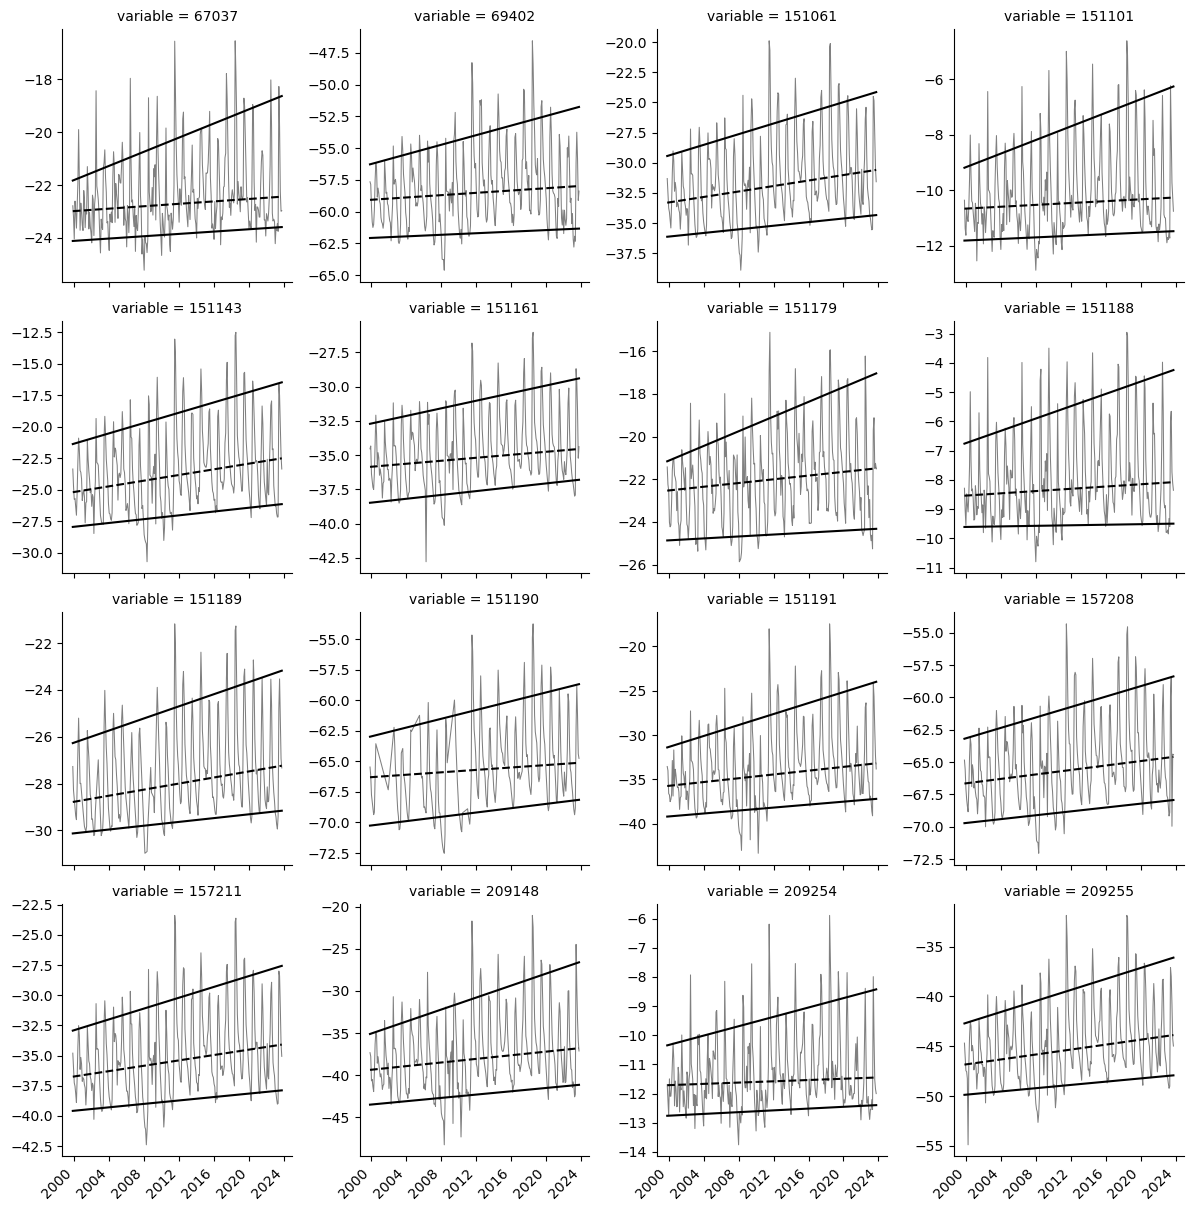

In [8]:
# Create the FacetGrid plot
g = sns.FacetGrid(df_trend, col='variable', col_wrap=4, sharey=False, sharex=True)

# Map the plot_data_and_trendline function to the FacetGrid
g.map_dataframe(viz.plot_data_and_quantreg)

# Rotate the x-tick labels on all subplots
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

plt.show()

### Calculate slope of the quantile regressions

In [9]:
gwicids = df_trend['variable'].unique()
df_quantreg = pd.DataFrame(columns=['gwicid', 'quantreg_m1', 'quantreg_m9', 'quantreg_m5'])
for gwicid in gwicids:
    data = df_trend[df_trend['variable'] == gwicid]
    q1, q9, q5 = viz.plot_data_and_quantreg(data, 'blue', quants=[0.1, 0.9], plot=False)
    m1, m9, m5 = q1.params.x, q9.params.x, q5.params.x
    new_data = [gwicid, m1, m9, m5]
    df_quantreg.loc[len(df_quantreg)] = new_data

/home/nick/miniforge3/envs/aquifer-base/lib/python3.10/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +



### Calculate correlation between slope and static variables

In [10]:
trends.index = trends.index.astype('int64')
df_stat = df_static.merge(trends, left_on='gwicid', right_index=True)
df_stat['gwicid'] = df_stat['gwicid'].astype(str)
df_stat = df_stat.merge(df_quantreg, left_on='gwicid', right_on='gwicid') 
corrmat = df_stat.corr()
corrslope = corrmat['slope']
corrslope

gwicid         0.329412
latitude       0.531288
longitude      0.835057
altitude       0.863497
total_dept     0.600128
swl            0.249227
cf_input      -0.851240
rs_input      -0.895295
gc_input      -0.643550
br_input       0.773840
outlet         0.436685
ksat_r        -0.348174
intercept     -0.672185
slope          1.000000
p-value       -0.514484
quantreg_m1    0.969605
quantreg_m9    0.852550
quantreg_m5    0.913119
Name: slope, dtype: float64

### Plot slope on map

In [11]:
# Convert to GeoDataFrame
df_stat['geometry'] = [Point(xy) for xy in zip(df_stat.longitude, df_stat.latitude)]
gdf_stat = gpd.GeoDataFrame(df_stat, geometry='geometry', crs='EPSG:4326')

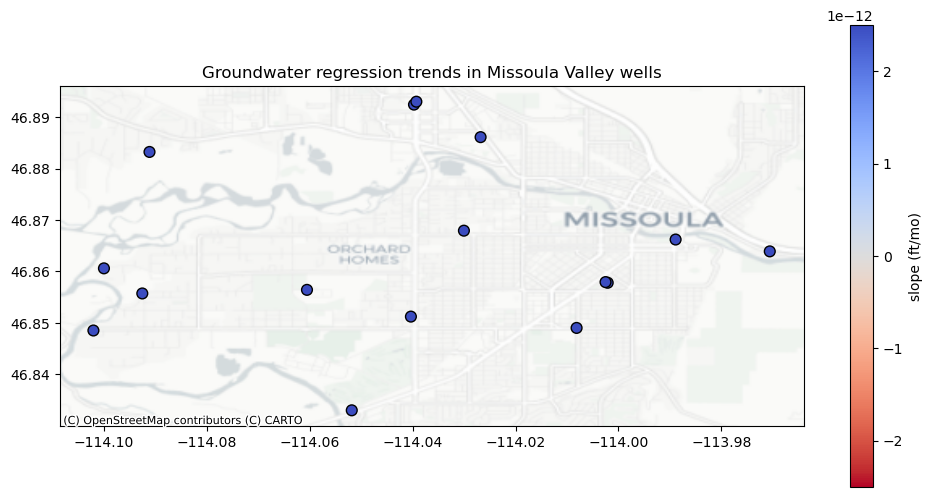

In [12]:
# Plot map of slope values
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='slope', 
                   cmap='coolwarm_r', 
                   legend=True, 
                #    vmin=-2.5e-09, 
                #    vmax=2.5e-09,
                   vmin=-2.5e-12, 
                   vmax=2.5e-12,
                   edgecolor='black',
                   s=60)
ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('slope (ft/mo)')
ax.set_title('Groundwater regression trends in Missoula Valley wells')
# ax.set_axis_off()
plt.show()

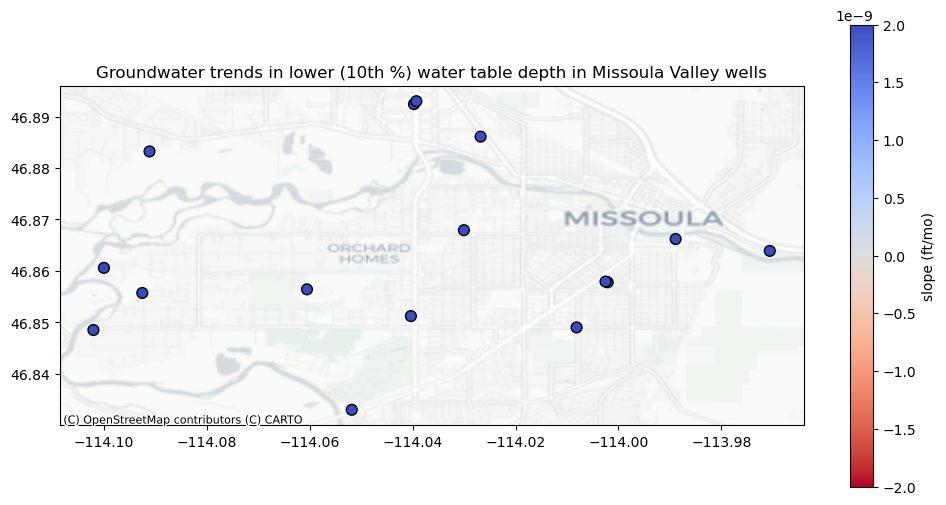

In [13]:
# Plot map of slope values
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='quantreg_m1', 
                   cmap='coolwarm_r', 
                   legend=True, 
                   vmin=-0.000000002, 
                   vmax=0.000000002,
                   edgecolor='black',
                   s=60)
ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('slope (ft/mo)')
ax.set_title('Groundwater trends in lower (10th %) water table depth in Missoula Valley wells')
# ax.set_axis_off()
plt.show()

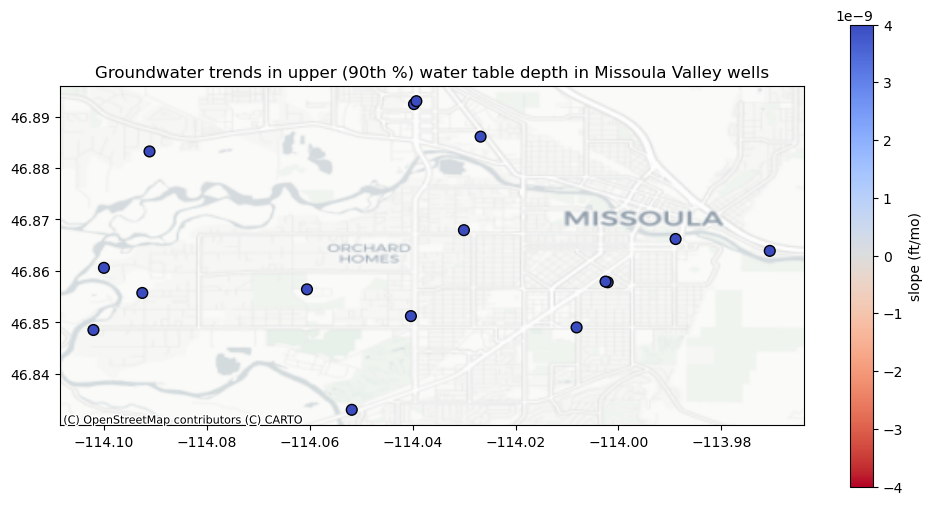

In [14]:
# Plot map of slope values
ax = gdf_stat.plot(figsize=(12, 6), 
                   column='quantreg_m9', 
                   cmap='coolwarm_r', 
                   legend=True, 
                   vmin=-0.000000004, 
                   vmax=0.000000004,
                   edgecolor='black',
                   s=60)
ctx.add_basemap(ax, 
                crs=gdf_stat.crs, 
                source=ctx.providers.CartoDB.Positron,
                zoom=12)
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('slope (ft/mo)')
ax.set_title('Groundwater trends in upper (90th %) water table depth in Missoula Valley wells')
# ax.set_axis_off()
plt.show()

### Groundwater and City pumping analysis

In [15]:
# average gw depth across all wells
df_norm['gw_avg'] = df_norm.iloc[:, 2:].mean(axis=1)

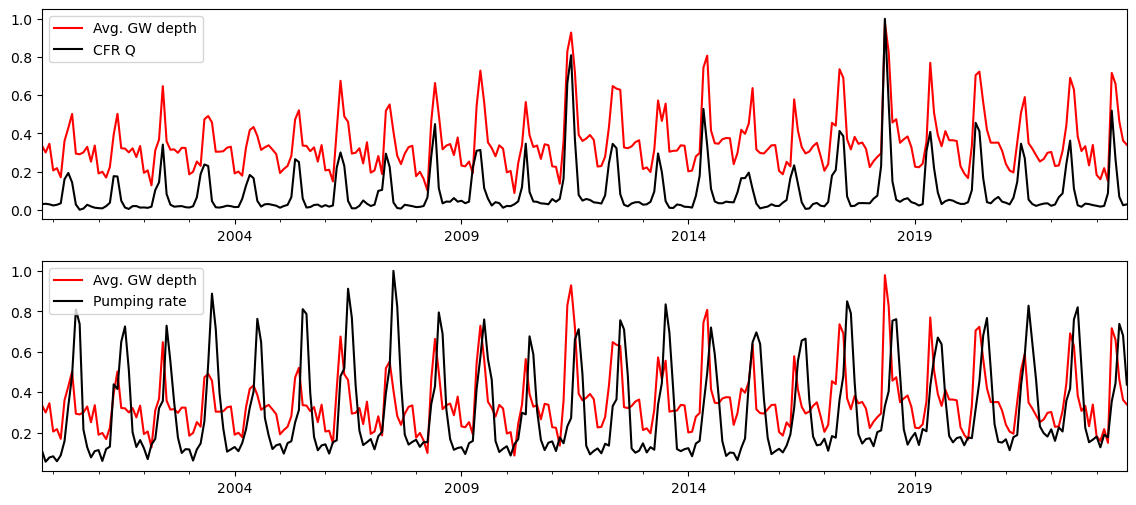

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(14, 6))
df_norm['gw_avg'].plot(ax=ax[0], color='red', label='Avg. GW depth')
df_norm['Q'].plot(ax=ax[0], color='black', label='CFR Q')
df_norm['gw_avg'].plot(ax=ax[1], color='red', label='Avg. GW depth')
df_norm['pumping_rate'].plot(ax=ax[1], color='black', label='Pumping rate')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

In [17]:
gw = df_norm['gw_avg'].dropna()

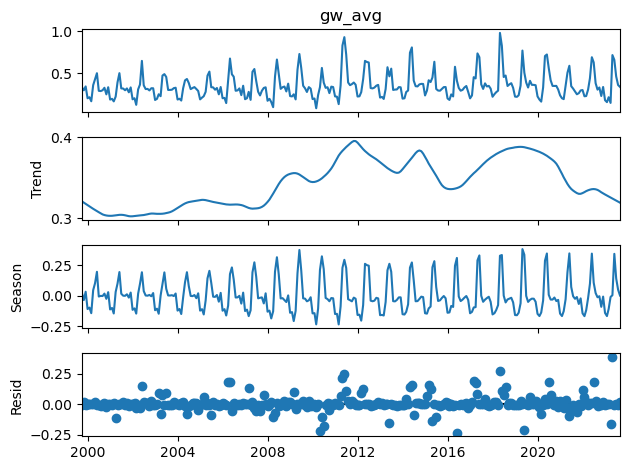

In [18]:
stl = STL(gw, seasonal=7, robust=True)
res = stl.fit()
res.plot()
plt.show()

In [19]:
res.resid.corr(df_norm.Q)

0.40092875804850214